In [1]:
import pyDOE3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initial reaction selection
* Reaction selection is conducted using generalized subset design (GSD) in order to reduce the full combinatorial design by a reduction factor while sampling the most informative reactions
* GSD works with categorial and numerical factors
* The code below takes the full search space as defined by each factor and all their levels and creates a new matrix that is the product of every level
* This complete search space is then reduced by a factor using GSD
* The rest of the code is used for generating the necessary reactions for the membrane protein experiments, i.e. adding replicates and corresponding no liposome reactions.

In [2]:
space = {
    'lipid':['DOPC','DMPC'],  
    'Mg':[8,14,20],
    'K':[85,185],
    'SecYE':[0,1.25],
    'PEG':[0,1,2]  
}
num_replicates = 5
num_plasmids = 8

levels = [len(space[key]) for key in space.keys()]
print(levels)
full_count = np.prod(levels)
print(f'Full design: {full_count} unique per plasmid')
reduction = 3
result = pyDOE3.gsd(levels, reduction)
print(f'Reduced: {len(result)} unique per plasmid')
print(f'With replicates: {len(result)*num_replicates*2} per plasmid')
print(f'Plates with replicates: {len(result)*num_replicates*num_plasmids/384}')
print(f'Plates with no liposome: {len(result)*num_replicates*num_plasmids/384*2}')



[3, 3, 2, 2, 3]
Full design: 108 unique per plasmid
Reduced: 36 unique per plasmid
With replicates: 360 per plasmid
Plates with replicates: 3.75
Plates with no liposome: 7.5


In [4]:
result_df = pd.DataFrame(result,columns=space.keys())
result_df.value_counts('lipid')

lipid
0    12
1    12
2    12
dtype: int64

In [5]:
def assign_value(row):
    return space[row['reagent']][row['number']]

result_df = pd.DataFrame(result,columns=space.keys())
res = result_df.stack().reset_index().rename(columns={'level_0':'rxn_id','level_1':'reagent',0:'number'})
res['value'] = res.apply(assign_value,axis=1)
res = res.drop(columns=['number'])
res = res.set_index(['rxn_id','reagent']).unstack()
res.columns = res.columns.droplevel()
res = res.reset_index()
res


reagent,rxn_id,K,Mg,PEG,SecYE,lipid
0,0,85,8,0,0,DOPC
1,1,85,8,1,1.25,DOPC
2,2,185,8,1,0,DOPC
3,3,185,8,2,1.25,DOPC
4,4,85,14,1,0,DOPC
5,5,85,14,2,1.25,DOPC
6,6,185,14,2,0,DOPC
7,7,185,14,0,1.25,DOPC
8,8,85,20,2,0,DOPC
9,9,85,20,0,1.25,DOPC


In [6]:
cols = [c for c in space.keys() if c not in ['lipid']]
cols

['Mg', 'K', 'SecYE', 'PEG']

In [7]:
no_lipo = res[cols].drop_duplicates().copy()
no_lipo['lipid'] = 'no_lipo'
no_lipo['rxn_id'] = len(res) + np.array(range(len(no_lipo)))

In [8]:
dnas = [
    'Aux',
    'AqpZ',
    'Glut',
    'B2AR',
    'Mito',
    'Mol',
    'Vol'
]
dnas

['Aux', 'AqpZ', 'Glut', 'B2AR', 'Mito', 'Mol', 'Vol']

In [9]:
all_unique = []

all_df = pd.concat([res,no_lipo]).reset_index(drop=True)

for i,dna in enumerate(dnas):
    temp = all_df.copy()
    temp['DNA_name'] = dna
    temp['rxn_id'] = temp['rxn_id'] + (i*len(all_df))
    all_unique.append(temp)
all_unique = pd.concat(all_unique).reset_index(drop=True)
all_unique


reagent,rxn_id,K,Mg,PEG,SecYE,lipid,DNA_name
0,0,85,8,0,0,DOPC,Aux
1,1,85,8,1,1.25,DOPC,Aux
2,2,185,8,1,0,DOPC,Aux
3,3,185,8,2,1.25,DOPC,Aux
4,4,85,14,1,0,DOPC,Aux
...,...,...,...,...,...,...,...
499,499,185,14,2,1.25,no_lipo,Vol
500,500,85,20,1,0,no_lipo,Vol
501,501,85,20,2,1.25,no_lipo,Vol
502,502,185,20,2,0,no_lipo,Vol


In [10]:
all_rxns = []

for rep in range(num_replicates):
    temp = all_unique.copy()
    temp['unique_id'] = temp['rxn_id'] + (rep * len(temp['rxn_id']))
    all_rxns.append(temp)
all_rxns = pd.concat(all_rxns)
all_rxns

reagent,rxn_id,K,Mg,PEG,SecYE,lipid,DNA_name,unique_id
0,0,85,8,0,0,DOPC,Aux,0
1,1,85,8,1,1.25,DOPC,Aux,1
2,2,185,8,1,0,DOPC,Aux,2
3,3,185,8,2,1.25,DOPC,Aux,3
4,4,85,14,1,0,DOPC,Aux,4
...,...,...,...,...,...,...,...,...
499,499,185,14,2,1.25,no_lipo,Vol,2515
500,500,85,20,1,0,no_lipo,Vol,2516
501,501,85,20,2,1.25,no_lipo,Vol,2517
502,502,185,20,2,0,no_lipo,Vol,2518


In [11]:
len(all_rxns)/384

6.5625

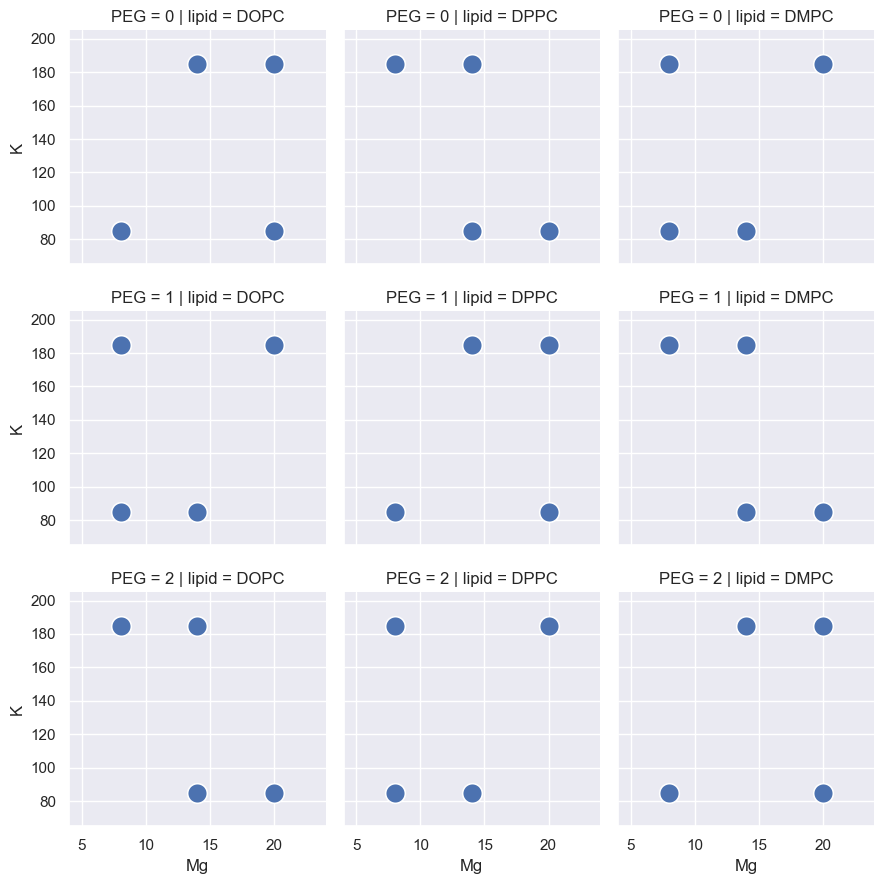

In [39]:
# plt.figure(figsize=[3,3])
# import seaborn as sns

# sns.set(rc={'figure.figsize':(8,8)})
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 3,3

sns.relplot(data=res,x='Mg',y='K',row='PEG',col='lipid',s=200,height=3, aspect=1)
plt.xlim([res['Mg'].min()-4,res['Mg'].max()+4])
plt.ylim([res['K'].min()-20,res['K'].max()+20])
# plt.grid(visible=None)

plt.show()